# BM25 retrieval with PyTerrier

In [1]:
from sys import modules

#%pip install tira ir-datasets python-terrier ir-measures
#if "google.colab" in modules:
    # This is only needed in Google Colab.
%pip install ir-datasets~=0.5.5 ir-measures~=0.3.3 python-terrier~=0.10.0 tira~=0.0.83 tqdm~=4.66 matplot


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 1: Import libraries and load variables

In [2]:

from pathlib import Path

from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run, ir_datasets

Ensure that the PyTerrier integration is loaded:

In [3]:
ensure_pyterrier_is_loaded()

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Due to execution in TIRA, I have patched ir_datasets to always return the single input dataset mounted to the sandbox.
Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.10.0 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [4]:
from pyterrier.batchretrieve import BatchRetrieve
from pyterrier.bootstrap import IndexFactory
from pyterrier.datasets import get_dataset
from pyterrier.index import IterDictIndexer
from pyterrier import Experiment, rewrite, GridScan
import matplotlib.pyplot as plt



Specify output directory for the run files:

In [5]:
output_directory = "./output"
index_directory = "./index"

### Step 2: Load the data

In [6]:
dataset = get_dataset("irds:ir-lab-jena-leipzig-wise-2023/training-20231104-training")
val_dataset = get_dataset("irds:ir-lab-jena-leipzig-wise-2023/validation-20231104-training")

qrels = dataset.get_qrels()
qrels


Load ir_dataset "ir-lab-jena-leipzig-wise-2023/training-20231104-training" from tira.
Load ir_dataset "ir-lab-jena-leipzig-wise-2023/validation-20231104-training" from tira.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.


,qid,docno,label,iteration
0,q06223196,doc062200112743,0,0
1,q06223196,doc062200205250,0,0
2,q06223196,doc062200101983,0,0
3,q06223196,doc062200204465,1,0
4,q06223196,doc062200115614,0,0
...,...,...,...,...
9651,q062225197,doc062200205276,0,0
9652,q062225197,doc062200107121,1,0
9653,q062225197,doc062200204419,0,0
9654,q062225197,doc062200103774,0,0


Let's look at the topics:

In [7]:
topics = dataset.get_topics(variant="title")
topics

No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.


,qid,query
0,q06223196,car shelter
1,q062228,airport
2,q062287,antivirus comparison
3,q06223261,free antivirus
4,q062291,orange antivirus
...,...,...
667,q062224914,tax garden shed
668,q062224961,land of france
669,q062225030,find my training pole job
670,q062225194,gpl car


And how many documents do we have for training?

In [8]:
print(f"The dataset has {dataset.irds_ref().docs_count()} documents.")

No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.


The dataset has 47064 documents.


The `docs_store` is a view of the dataset for accessing documents with random access.

In [9]:
docs_store = dataset.irds_ref().docs_store()

Let's look at the document with the ID `doc062200109610`:

In [10]:
print(docs_store.get("doc062200109610"))

GenericDoc(doc_id='doc062200109610', text='\n\nEDF\n-\nGDF School-Valentine (25480)\n- Opening of electricity and gas meter Opening of your electricity or gas meter at École-Valentin on the Enedis/ErDF or GrDF network with papernest Free and non-binding service Announcement\n- papernest is not a partner of EDF.\nThank you.\nYour request has been taken into account A counsellor will call you back to the I understood\nIt seems that there is an error with our service Try again Opening your electricity or gas meter at École-Valentin on the Enedis/ErDF or GrDF network\nwith agence-france-electricite.fr Call the Me to call back Simple and quick: 5 minutes is enough No commitment or cancellation fee On 13 users Announcement\n- agency-france-electricite.fr\nis not a partner of Edf Contacts and rates of Engie gas offers to École-Valentin\nEngie\n, formerly SFM\nSuez, is one of the main suppliers of energy in Franche-Comté and throughout France.\nThe company emerged from the merger between Suez 

### Step 3: Create the index

In [11]:
if Path(index_directory).exists():
    index_ref = index_directory
else:
    indexer = IterDictIndexer("./index", overwrite=True)
    index_ref = indexer.index(dataset.get_corpus_iter(verbose=True))
index = IndexFactory.of(index_ref)

### Step 4: Create retrieval pipeline

#### Tune hyperparameter of PL2

In [29]:
pl2 = BatchRetrieve(index, wmodel="PL2", controls={'c': 1})
rtr = GridScan(
    pl2,
    {pl2: {'c': [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]}},
    topics,
    qrels,
    "map"
)

#### Visualize dependency of PL2 on parameter c

    tran_0  tran_0_c       map
0  BR(PL2)       1.0  0.141104
1  BR(PL2)       1.1  0.141448
2  BR(PL2)       1.2  0.141684
3  BR(PL2)       1.3  0.142120
4  BR(PL2)       1.4  0.142582
5  BR(PL2)       1.5  0.142437
6  BR(PL2)       1.6  0.142150
7  BR(PL2)       1.7  0.142185
8  BR(PL2)       1.8  0.141726


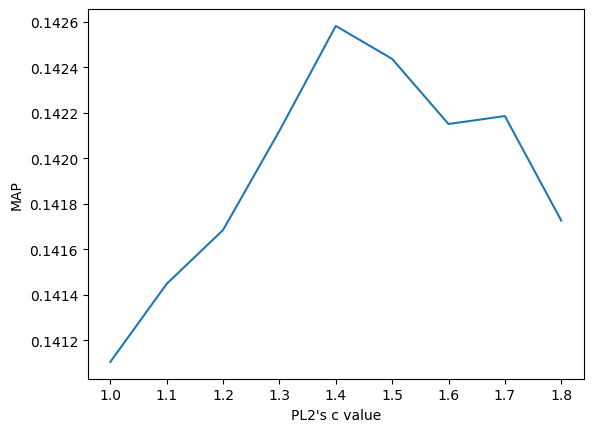

In [30]:
print(rtr)
plt.plot(rtr["tran_0_c"], rtr["map"])
plt.xlabel("PL2's c value")
plt.ylabel("MAP")
plt.show()

#### For retrieval with PL2 c=1.4 seems to work best

In [31]:
pl2 = BatchRetrieve(index, wmodel="PL2", verbose=True, controls={"b" : 1.4})

#### Next, we want to experiment with query expansion for retrieval with BM25.

In [32]:
bm25 = BatchRetrieve(index, wmodel="BM25", verbose=True, controls={"b" : 0.8})
#bm25= ~bm25

bo1_expansion = ~bm25 >> rewrite.Bo1QueryExpansion(index)
bm25_bo1 = bo1_expansion >> bm25
#bm25_bo1= ~bm25_bo1

kl = ~bm25 >> rewrite.KLQueryExpansion(index)
bm25_kl = kl >> bm25
#bm25_kl= ~bm25_kl


#### Additionally, we linearly combine retrieval with BM25 and PL2.

In [33]:
bm25_bo1_pl2 = (2* bm25_bo1 + pl2).transform(topics)
bm25_kl_pl2 = (2* bm25_kl + pl2).transform(topics)

BR(PL2): 100%|██████████| 672/672 [00:15<00:00, 44.58q/s]


#### Let's run an experiment, so see which retrieval works best.

In [34]:
Experiment(
    [~bm25, bm25_bo1, bm25_kl, bm25_bo1_pl2, bm25_kl_pl2], 
    topics, dataset.get_qrels(), 
    eval_metrics=["ndcg", "map", "recip_rank", "P_10", "recall_10"],
    names=["BM25", "BM25 >> Bo1 >> BM25", "BM25 >> KL >> BM25", "BM25 >> Bo1 >> BM25 w\ PL2", "BM25 >> KL >> BM25 w\ PL2"],
    baseline = 0
)



BR(BM25): 100%|██████████| 671/671 [00:17<00:00, 37.41q/s]


,name,map,recip_rank,P_10,recall_10,ndcg,map +,map -,map p-value,recip_rank +,...,recip_rank p-value,P_10 +,P_10 -,P_10 p-value,recall_10 +,recall_10 -,recall_10 p-value,ndcg +,ndcg -,ndcg p-value
0,BM25,0.148430,0.262423,0.093452,0.239859,0.314700,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 >> Bo1 >> BM25,0.154476,0.260961,0.094048,0.242239,0.323335,340.0,278.0,0.089207,252.0,...,0.856675,84.0,76.0,0.789492,84.0,76.0,0.733174,345.0,275.0,0.014020
2,BM25 >> KL >> BM25,0.153066,0.257133,0.094494,0.241492,0.321609,343.0,273.0,0.180260,247.0,...,0.500097,81.0,71.0,0.630230,81.0,71.0,0.811972,343.0,275.0,0.042616
3,BM25 >> Bo1 >> BM25 w\ PL2,0.156237,0.267786,0.095685,0.244831,0.327790,367.0,252.0,0.009595,258.0,...,0.437693,86.0,71.0,0.311126,86.0,71.0,0.459533,370.0,250.0,0.000013
4,BM25 >> KL >> BM25 w\ PL2,0.155325,0.260767,0.095833,0.244435,0.326385,356.0,264.0,0.021933,249.0,...,0.807686,85.0,70.0,0.287526,85.0,70.0,0.500413,365.0,256.0,0.000088


#### The combination of BM25 with Bo1 query expansion and PL2 performs slightly better than the others. 

### Step 5: Create the run
#### Let's look at a few results of the run:

In [35]:
bm25_bo1_pl2.head(10)


,qid,docid,docno,score,query_0,query,rank
0,q062210081,5457.0,doc062200206592,55.609508,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,0
1,q062210081,36071.0,doc062200101758,52.060024,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,1
2,q062210081,7541.0,doc062200101893,50.956214,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,3
3,q062210081,3212.0,doc062200109914,51.307571,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,2
4,q062210081,33114.0,doc062210912628,50.922367,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,4
5,q062210081,10951.0,doc062200113739,47.330069,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,6
6,q062210081,24575.0,doc062200308829,47.064209,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,7
7,q062210081,16845.0,doc062200602177,49.504651,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,5
8,q062210081,17933.0,doc062200503293,45.545072,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,9
9,q062210081,38338.0,doc062200402611,45.569985,consumption water home,applypipeline:off consumpt^1.244622420 water^1...,8


### Step 6: Persist run

Perfect! All that's left is to persist the run in the standard TREC format:

In [37]:
persist_and_normalize_run(bm25_bo1_pl2, output_file=output_directory, system_name="BM25_Bo1_PL2", depth=1000)

Done. run file is stored under "./output/run.txt".
